In [1]:
# http://db.csail.mit.edu/labdata/labdata.html

In [1]:
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression # importa o modelo
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import sklearn.manifold as skm
from sklearn import metrics
import scipy.stats as stats
import seaborn as sns
import random as rdn
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import time

## Reading Dataset

In [159]:
# setting names to columns
data_column_names = ["Date", "Time", "Epoch", "Moteid", "Temperature", "Humidity", "Light", "Voltage"]
data = pd.read_csv("dataset/data.txt", delimiter = " ", names = data_column_names)

In [3]:
data.head(3)

Date             Time  Epoch  Moteid  Temperature  Humidity  Light  \
0  2004-03-31  03:38:15.757551      2     1.0     122.1530  -3.91901  11.04   
1  2004-02-28   00:59:16.02785      3     1.0      19.9884  37.09330  45.08   
2  2004-02-28   01:03:16.33393     11     1.0      19.3024  38.46290  45.08   

   Voltage  
0  2.03397  
1  2.69964  
2  2.68742

In [160]:
data = data[(data["Epoch"] <= 5576) & (data["Epoch"] > 1)] 

### Missing Data

Text(0,0.5,'Percentage')

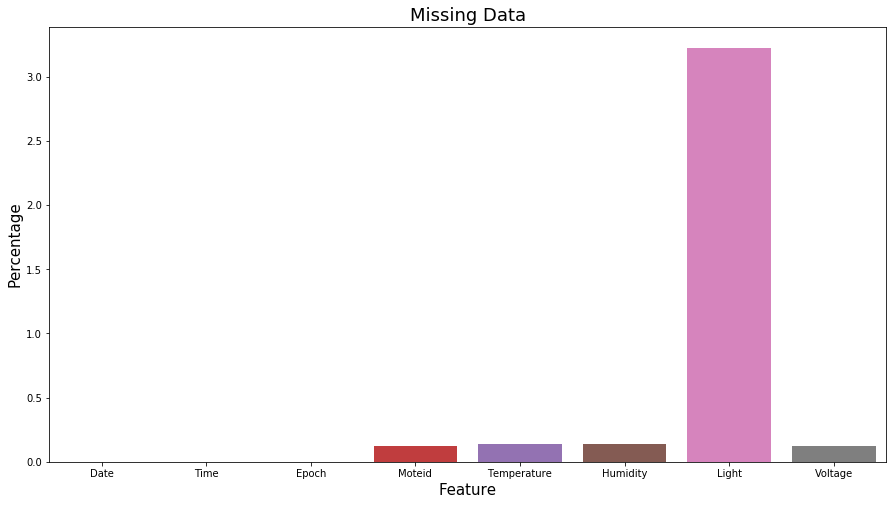

In [14]:
missing = pd.DataFrame((data.isnull().sum() * 100 )/ data.shape[0]).reset_index().rename(columns = {'index': 'Feature', 0: 'Percent'})
p = sns.barplot(x = 'Feature', y = 'Percent', data = missing, ax = plt.subplots(figsize = (15, 8))[1])
p.set_title('Missing Data', fontsize = 18)
p.set_xlabel('Feature', fontsize = 15)
p.set_ylabel('Percentage', fontsize = 15)

In [161]:
# change features order
data = data[["Moteid", "Epoch", "Humidity", "Light", "Voltage", "Date", "Time", "Temperature"]]

## Change dataset

### Creating a dataframe with means

In [162]:
# percorrendo as features
epocas = np.sort(data["Epoch"].unique())
means = {"Temperature": [], "Humidity": [], "Light": [], "Voltage": []}
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:   
    for epoch in epocas:
        means[feature].append(data[data['Epoch'] == epoch][feature].mean())
        
means_epochs = pd.DataFrame(means).set_index(epocas).reset_index().rename(columns = {'index': 'Epoch'})

In [175]:
# replacing data

# parsing in the features
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    # first epoch
    aux = data[data['Epoch'] == 2].copy()
    index_ = aux[aux[feature].isnull()].index
    data.loc[index_, feature] = means_epochs[means_epochs['Epoch'] == 3][feature].values[0]
    
    # last epoch
    aux = data[data['Epoch'] == 5576].copy()
    index_ = aux[aux[feature].isnull()].index
    data.loc[index_, feature] = means_epochs[means_epochs['Epoch'] == 5575][feature].values[0]
    
    for epoch in range(1, len(epocas) - 1):
        aux = data[data['Epoch'] == epocas[epoch]].copy()
        index_ = aux[aux[feature].isnull()].index
        
        data.loc[index_, feature] = (means_epochs[means_epochs['Epoch'] == epocas[epoch - 1]][feature].values[0] + \
                                    means_epochs[means_epochs['Epoch'] == epocas[epoch + 1]][feature].values[0]) / 2        

In [179]:
outliers = data.copy()

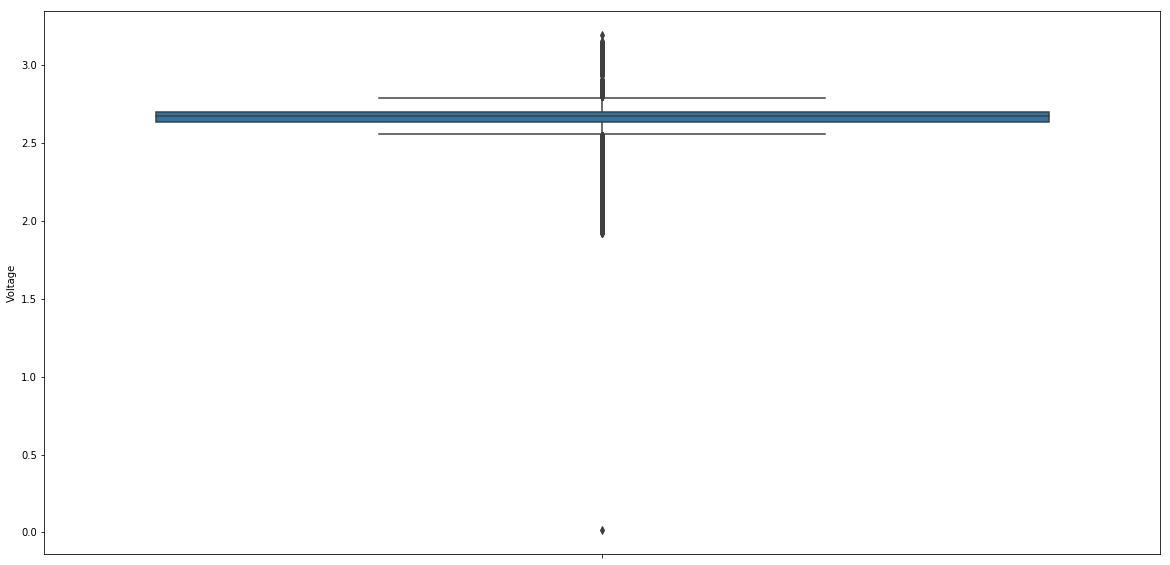

In [187]:
ax = sns.boxplot(y="Voltage", data=outliers, ax = plt.subplots(figsize = (20, 10))[1])

## Creating a model

In [48]:
# array of epochs
epochs = new_data['Epoch'].unique()[:5]

In [51]:
new_data.shape

(177, 8)

In [50]:
new_data = new_data[new_data['Epoch'].isin(epochs)]

In [133]:
regr = LinearRegression()

features_ = []
for feature in ['Light', 'Voltage', 'Humidity']:
    epochs_error_mean = []
    epochs_error_sqrt = []
    for ep in epochs:
        
        X_train, y_train = new_data[new_data['Epoch'] != ep][[feature]], new_data[new_data['Epoch'] != ep]['Temperature']
        X_test, y_test = new_data[new_data['Epoch'] == ep][[feature]], new_data[new_data['Epoch'] == ep]['Temperature']

        regr.fit(X_train, y_train) # fitting model

        y_pred = regr.predict(X_test)
        error = mean_squared_error(y_test, y_pred)

        epochs_error_mean.append(error) # array of mean squared errors
        epochs_error_sqrt.append(np.sqrt(error)) # array of sqrt mean squared error
    
    features_.append(epochs_error_mean)
#epochs_error_mean
pd.DataFrame(np.array(features_).T, columns = ['Temp~Light', 'Temp~Voltage', 'Temp~Humidity']).set_index(epochs).reset_index().rename(columns = {'index': 'Epoch'})
#np.array(features_).shape

Epoch   Temp~Light  Temp~Voltage  Temp~Humidity
0      2  3907.348593   1052.484763     665.123915
1     21   668.381371    223.623566      12.415613
2     25   666.834049    262.453161      10.083226
3     58   604.495781    150.576558      10.268495
4     61   203.860043    129.883504      11.594031

In [112]:
X2 = new_data[['Humidity']]
y2 = new_data['Temperature']
regr2 = LinearRegression()
regr2.fit(X2, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
new_data[new_data['Epoch'] == 2].shape

(38, 8)

In [128]:
new_data.Epoch.unique()
[143.76260022250588, 143.76260022250588, 143.76260022250588, 143.76260022250588, 143.76260022250588]

array([ 2, 21, 25, 58, 61], dtype=int64)

In [131]:
count = 0
mean_epoch=[]
for i in new_data.Epoch.unique():
    aux = new_data[new_data['Epoch']==2]
    print(aux.shape)
    scores = cross_val_score(regr2, X2, y2, cv=aux.shape[0], scoring='mean_squared_error')
    mean_epoch.append(abs(scores).mean()) 
#     mean_epoch.append(abs(scores)) 
    count+=1
#     if count==38:
#         break
print(mean_epoch)

(38, 8)
(38, 8)

C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_square

C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_square


(38, 8)
(38, 8)


C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_square

(38, 8)
[143.76260022250588, 143.76260022250588, 143.76260022250588, 143.76260022250588, 143.76260022250588]


C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_square

In [91]:
epochs_error_mean

[665.1239146876059,
 12.415612680189163,
 10.083225852101558,
 10.268495176446756,
 11.594031480074635]

In [45]:
X = new_data[['Voltage']] #'Light', 'Voltage', Humidity]]
y = new_data['Temperature']

In [46]:
# cria o modelo
regr = LinearRegression()

regr.fit(X, y) # treina o modelo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
mean_squared_error(y, regr.predict(X))

368.03406495362265

In [21]:
scores = cross_val_score(regr, X, y, cv=5, scoring='mean_squared_error')
scores

C:\Users\crislanio_macedo\AppData\Local\Continuum\anaconda3\CONDA\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\crislanio_macedo\AppData\Local\Continuum\anaconda3\CONDA\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\crislanio_macedo\AppData\Local\Continuum\anaconda3\CONDA\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\crislanio_macedo\AppData\Local\Continuum\anaconda3\CONDA\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method m

array([-1058.93386521,  -705.91746446,  -682.8239322 ,  -501.48794284,
        -344.77656323])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
#imprimindo os valores
# print('Utilizando biblioteca scikit-learn no python')
# print('y = ax + b')
# print('a = %.2f = a inclinação da linha de tendência.' % regr.coef_)
# print('b = %.2f = o ponto onde a linha de tendência atinge o eixo y.' % regr.intercept_[0])

In [30]:
r2_train = regr.score(X_train, y_train)
r2_test = regr.score(X_test, y_test)
print('R2 no set de treino: %.2f' % r2_train)
print('R2 no set de teste: %.2f' % r2_test)

R2 no set de treino: 0.03
R2 no set de teste: 0.01


In [1]:
import pandas as pd
from sklearn import linear_model

#carregando dados hipotéticos, para fins didáticos apenas
dataframe = pd.DataFrame()
dataframe['x'] = [5.1, 5.5, 5.9, 6.5, 6.8, 7.6, 8.3, 8.5, 9.1, 9.5]  # horas de estudo
dataframe['y'] = [2.0, 2.9, 4.0, 5.9, 6.0, 6.9, 8.0, 9.0, 9.9, 11.0] # pontuaçao alcançada
x_values = dataframe[['x']]
y_values = dataframe[['y']]

#treinando o modelo
model = linear_model.LinearRegression()
model.fit(x_values, y_values)

#imprimindo os valores
print('Utilizando biblioteca scikit-learn no python')
print('y = ax + b')
print('a = %.2f = a inclinação da linha de tendência.' % model.coef_[0][0])
print('b = %.2f = o ponto onde a linha de tendência atinge o eixo y.' % model.intercept_[0])

Utilizando biblioteca scikit-learn no python
y = ax + b
a = 1.92 = a inclinação da linha de tendência.
b = -7.39 = o ponto onde a linha de tendência atinge o eixo y.
